In [ ]:
import os
import numpy as np
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))
conv_base.summary()

In [6]:
# Featrure extract without data enforcement
base_dir = '/home/yahu/demos/python/data/cats_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.


Found 1000 images belonging to 2 classes.


Found 1000 images belonging to 2 classes.


In [ ]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(1, activation='sigmoid'))
network.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                loss='binary_crossentropy',
                metrics=['acc'])
history = network.fit(train_features,
                      train_labels,
                      epochs=30,
                      batch_size=20,
                      validation_data=(validation_features,
                                       validation_labels))

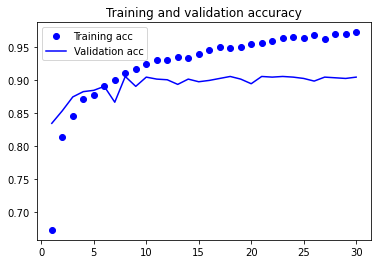

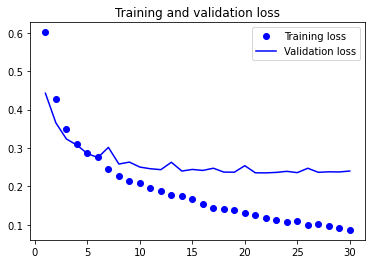

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
network2 = models.Sequential()
network2.add(conv_base)
network2.add(layers.Flatten())
network2.add(layers.Dense(256, activation='relu'))
network2.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

network2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = network2.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

In [33]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def draw_acc_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
    plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
    plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
draw_acc_and_loss(history)

In [ ]:
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
    else:
        layer.trainable = False

network2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = network2.fit_generator(train_generator,
                                 steps_per_epoch=100,
                                 epochs=100,
                                 validation_data=validation_generator,
                                 validation_steps=50)

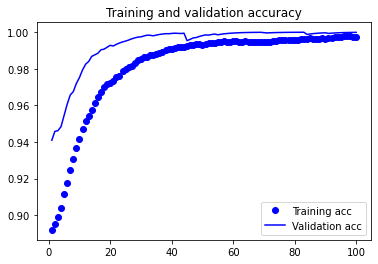

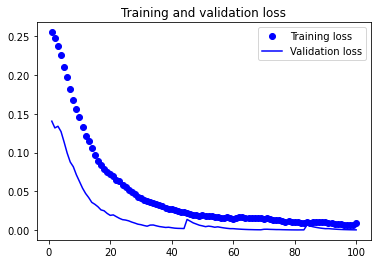

In [34]:
draw_acc_and_loss(history)

In [22]:
# Test model
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = network2.evaluate(test_generator, steps=50)
print('test_acc:', test_acc)

Found 1000 images belonging to 2 classes.


 1/50 [..............................] - ETA: 0s - loss: 0.1455 - acc: 0.9500

 2/50 [>.............................] - ETA: 40s - loss: 0.2840 - acc: 0.9250

 3/50 [>.............................] - ETA: 52s - loss: 0.2759 - acc: 0.9333

 4/50 [=>............................] - ETA: 58s - loss: 0.6304 - acc: 0.8875

 5/50 [==>...........................] - ETA: 1:00 - loss: 0.6392 - acc: 0.9000

 6/50 [==>...........................] - ETA: 1:02 - loss: 0.5730 - acc: 0.9083

 7/50 [===>..........................] - ETA: 1:02 - loss: 0.6322 - acc: 0.9071

 8/50 [===>..........................] - ETA: 1:02 - loss: 0.5532 - acc: 0.9187

 9/50 [====>.........................] - ETA: 1:01 - loss: 0.8002 - acc: 0.9111

10/50 [=====>........................] - ETA: 1:01 - loss: 0.7556 - acc: 0.9100

11/50 [=====>........................] - ETA: 1:00 - loss: 0.9571 - acc: 0.9000

12/50 [======>.......................] - ETA: 59s - loss: 0.8967 - acc: 0.9042 

13/50 [======>.......................] - ETA: 58s - loss: 0.8816 - acc: 0.9077

14/50 [=======>......................] - ETA: 57s - loss: 0.8679 - acc: 0.9036

15/50 [========>.....................] - ETA: 55s - loss: 0.8104 - acc: 0.9100

16/50 [========>.....................] - ETA: 54s - loss: 0.7856 - acc: 0.9094

17/50 [=========>....................] - ETA: 52s - loss: 0.7435 - acc: 0.9118

18/50 [=========>....................] - ETA: 51s - loss: 0.7282 - acc: 0.9139

19/50 [==========>...................] - ETA: 50s - loss: 0.7094 - acc: 0.9132

20/50 [===========>..................] - ETA: 48s - loss: 0.7455 - acc: 0.9125

21/50 [===========>..................] - ETA: 47s - loss: 0.7659 - acc: 0.9143

22/50 [============>.................] - ETA: 45s - loss: 0.7434 - acc: 0.9159

23/50 [============>.................] - ETA: 43s - loss: 0.7452 - acc: 0.9152

24/50 [=============>................] - ETA: 42s - loss: 0.7536 - acc: 0.9125

25/50 [==============>...............] - ETA: 40s - loss: 0.7239 - acc: 0.9160

26/50 [==============>...............] - ETA: 39s - loss: 0.7374 - acc: 0.9154

27/50 [===============>..............] - ETA: 37s - loss: 0.7252 - acc: 0.9148

28/50 [===============>..............] - ETA: 36s - loss: 0.6993 - acc: 0.9179

29/50 [================>.............] - ETA: 34s - loss: 0.6752 - acc: 0.9207

30/50 [=================>............] - ETA: 32s - loss: 0.6527 - acc: 0.9233

31/50 [=================>............] - ETA: 31s - loss: 0.6697 - acc: 0.9226

32/50 [==================>...........] - ETA: 29s - loss: 0.6635 - acc: 0.9234

33/50 [==================>...........] - ETA: 28s - loss: 0.6441 - acc: 0.9258

34/50 [===================>..........] - ETA: 26s - loss: 0.6253 - acc: 0.9279

35/50 [====================>.........] - ETA: 24s - loss: 0.6227 - acc: 0.9286

36/50 [====================>.........] - ETA: 23s - loss: 0.6143 - acc: 0.9292

37/50 [=====================>........] - ETA: 21s - loss: 0.6225 - acc: 0.9284

38/50 [=====================>........] - ETA: 19s - loss: 0.6090 - acc: 0.9289

39/50 [======================>.......] - ETA: 18s - loss: 0.6003 - acc: 0.9295

40/50 [=======================>......] - ETA: 16s - loss: 0.5855 - acc: 0.9312

41/50 [=======================>......] - ETA: 14s - loss: 0.5713 - acc: 0.9329

42/50 [========================>.....] - ETA: 13s - loss: 0.5627 - acc: 0.9333

43/50 [========================>.....] - ETA: 11s - loss: 0.5577 - acc: 0.9326

44/50 [=========================>....] - ETA: 10s - loss: 0.5472 - acc: 0.9330

45/50 [==========================>...] - ETA: 8s - loss: 0.5482 - acc: 0.9322 

46/50 [==========================>...] - ETA: 6s - loss: 0.5378 - acc: 0.9326

47/50 [===========================>..] - ETA: 5s - loss: 0.5354 - acc: 0.9319

48/50 [===========================>..] - ETA: 3s - loss: 0.5385 - acc: 0.9312

49/50 [============================>.] - ETA: 1s - loss: 0.5452 - acc: 0.9306

50/50 [==============================] - ETA: 0s - loss: 0.5536 - acc: 0.9300

50/50 [==============================] - 84s 2s/step - loss: 0.5536 - acc: 0.9300


test_acc: 0.9300000071525574


In [23]:
model_path = '/home/yahu/demos/python/models/'
network2.save(model_path + 'cats_and_dogs.h5')